In [1]:
import numpy as np
from scipy.stats.distributions import gamma, expon, burr, logistic, loggamma, lognorm
from scipy.stats.kde import gaussian_kde
from scipy.stats import kstest, cramervonmises
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings
import pandas as pd


style.use("seaborn-white")
plt.rc("figure", figsize=(20, 20))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

/Users/dmitrij/PycharmProjects/itmo_mma/.venv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = pd.read_csv("../london_merged.csv", parse_dates=["timestamp"], index_col="timestamp")
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
# choosing subsample from the dataset
chosen_vars = {
    'cnt': [df[(df.index.hour == 0) & (df.is_weekend == 0)].cnt, 'gamma'],
    't1': [df[(df.index.hour == 10)].t1, 'loggamma'],
    'hum': [df[(df.index.hour == 21)].hum, 'loggamma']
}

In [4]:
# plotting histogram along with kernel density estimation of PDF
def kde_estimation(series, bins=50, ax=plt):
    density = gaussian_kde(series)
    x = np.linspace(series.min(), series.max(), 100)
    ax.hist(series, bins=bins, density=True)
    ax.plot(x, density(x), linewidth=3)
    ax.title.set_text(series.name)

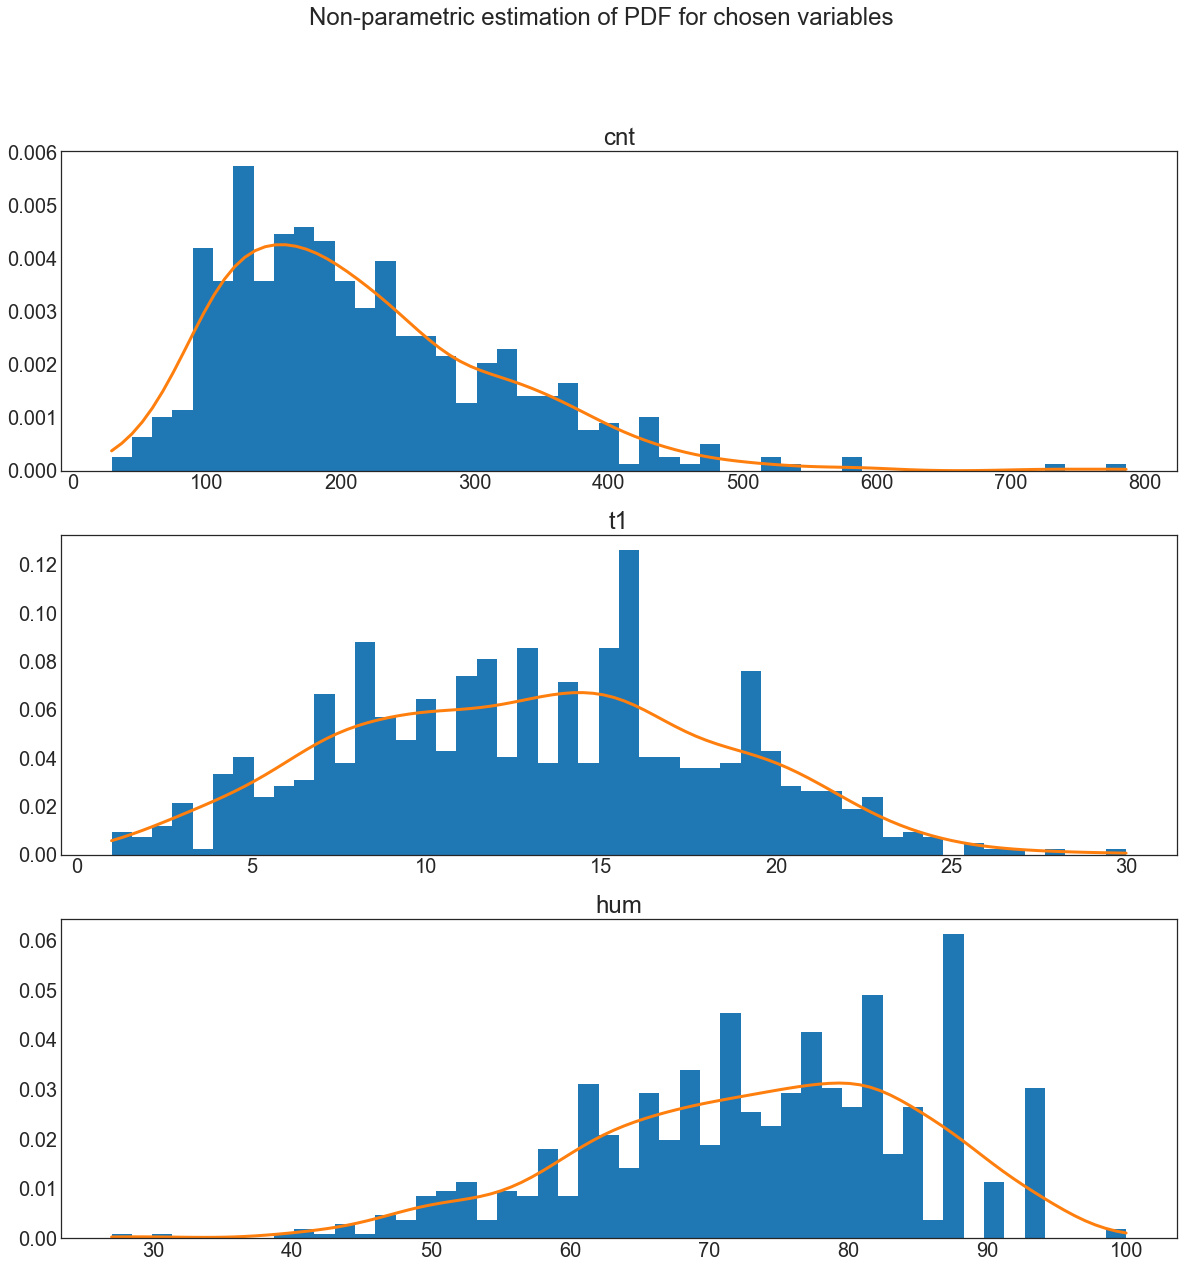

In [5]:
_, axes = plt.subplots(nrows=3)
plt.suptitle('Non-parametric estimation of PDF for chosen variables')
for i, key in enumerate(chosen_vars.keys()):
    kde_estimation(chosen_vars[key][0], ax=axes.flatten()[i])

In [6]:
# estimation of order statistics
df[chosen_vars].describe()

,cnt,t1,hum
count,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,72.324954
std,1085.108068,5.571818,14.313186
min,0.000000,-1.500000,20.500000
25%,257.000000,8.000000,63.000000
50%,844.000000,12.500000,74.500000
75%,1671.750000,16.000000,83.000000
max,7860.000000,34.000000,100.000000


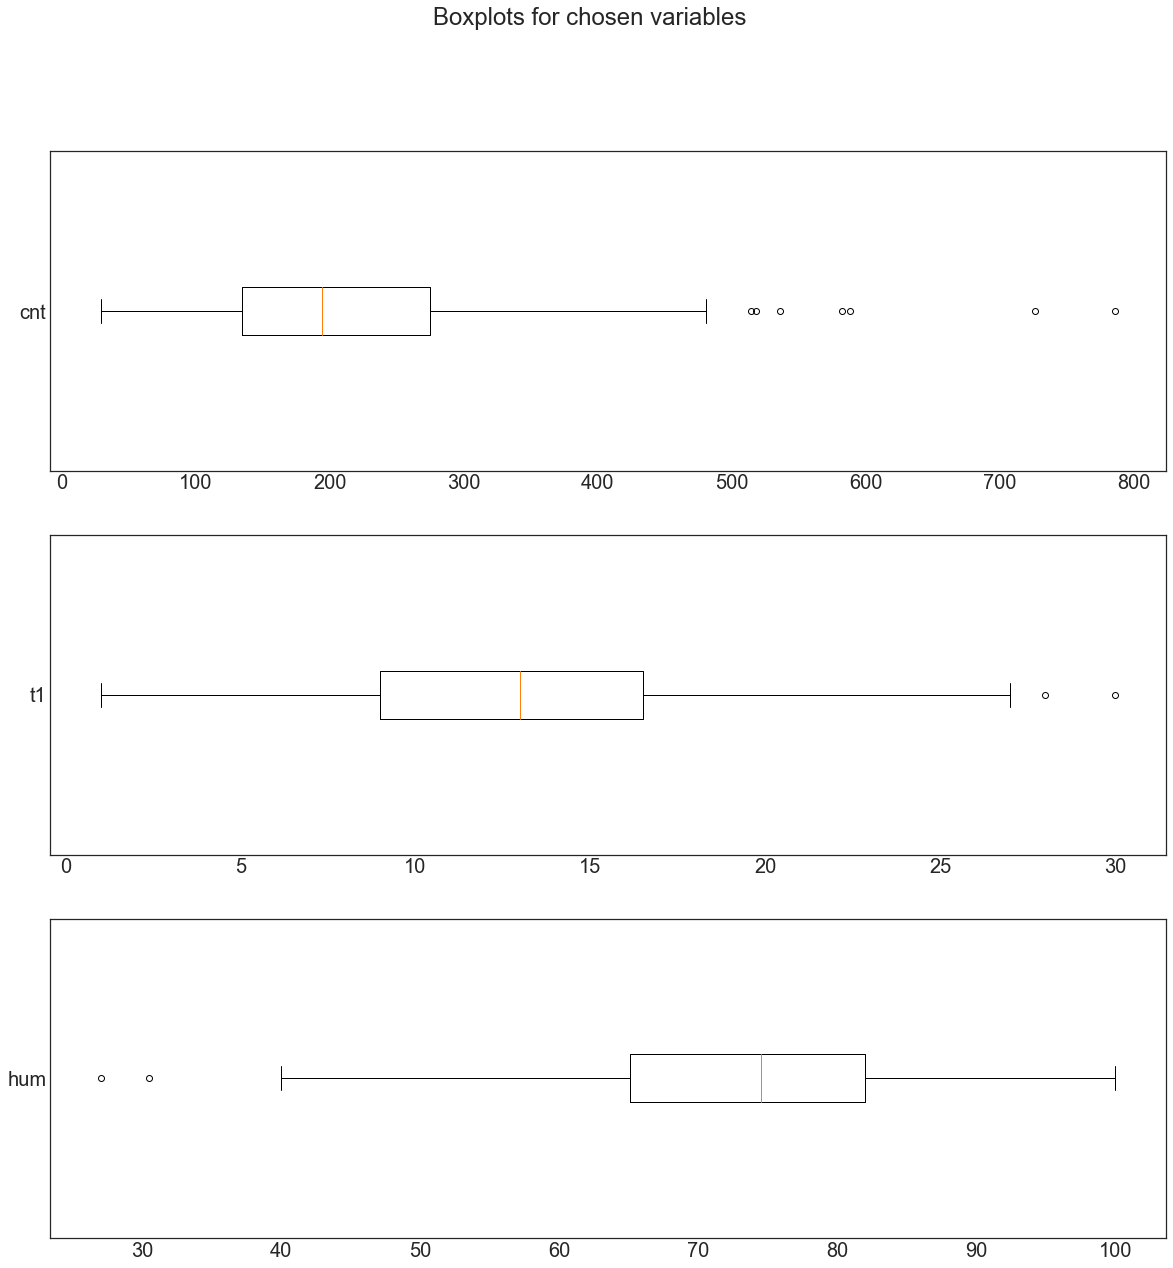

In [7]:
_, axes = plt.subplots(nrows=3)
plt.suptitle('Boxplots for chosen variables')
for i, key in enumerate(chosen_vars.keys()):
    axes.flatten()[i].boxplot(chosen_vars[key][0], vert=False, labels=[key]);

In [30]:
# estimating distribution parameters using fit method (which uses MLE method)
def get_distribution_mle(series, distribution, bins=50, ax=None):
    params = distribution.fit(series)
    y, x = np.histogram(series, density=True, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    estimated_dist = distribution.pdf(x, *params)
    if ax is not None:
        ax.hist(series, density=True, bins=bins)
        ax.plot(x, estimated_dist, linewidth=3)
        ax.title.set_text(series.name)
    return params

# estimating distribution parameters using scipy.optimize.curve_fit method (which uses ls method)
def get_distribution_ls(series, distribution, bins=50, ax=None):
    y, x = np.histogram(series, density=True, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    params, _ = curve_fit(distribution.pdf, x, y, p0=[1, 1, 10], maxfev=100000)
    estimated_dist = distribution.pdf(x, *params)
    if ax is not None:
        ax.hist(series, density=True, bins=bins)
        ax.plot(x, estimated_dist, linewidth=3)
        ax.title.set_text(series.name)
    return params

def plot_mle_ls(series, distribution, ax, bins=50):
    y, x = np.histogram(series, density=True, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    params_mle = eval(distribution).fit(series)
    params_mse, _ = curve_fit(eval(distribution).pdf, x, y, p0=[1, 1, 10], maxfev=100000)
    
    estimated_dist_mle = eval(distribution).pdf(x, *params_mle)
    estimated_dist_mse = eval(distribution).pdf(x, *params_mse)
    
    ax.hist(series, density=True, bins=bins)
    ax.plot(x, estimated_dist_mle, linewidth=3, label=f"MLE estimated {distribution} distribution")
    ax.plot(x, estimated_dist_mse, linewidth=3, label=f"LS estimated {distribution} distribution")
    ax.title.set_text(series.name)
    ax.legend()

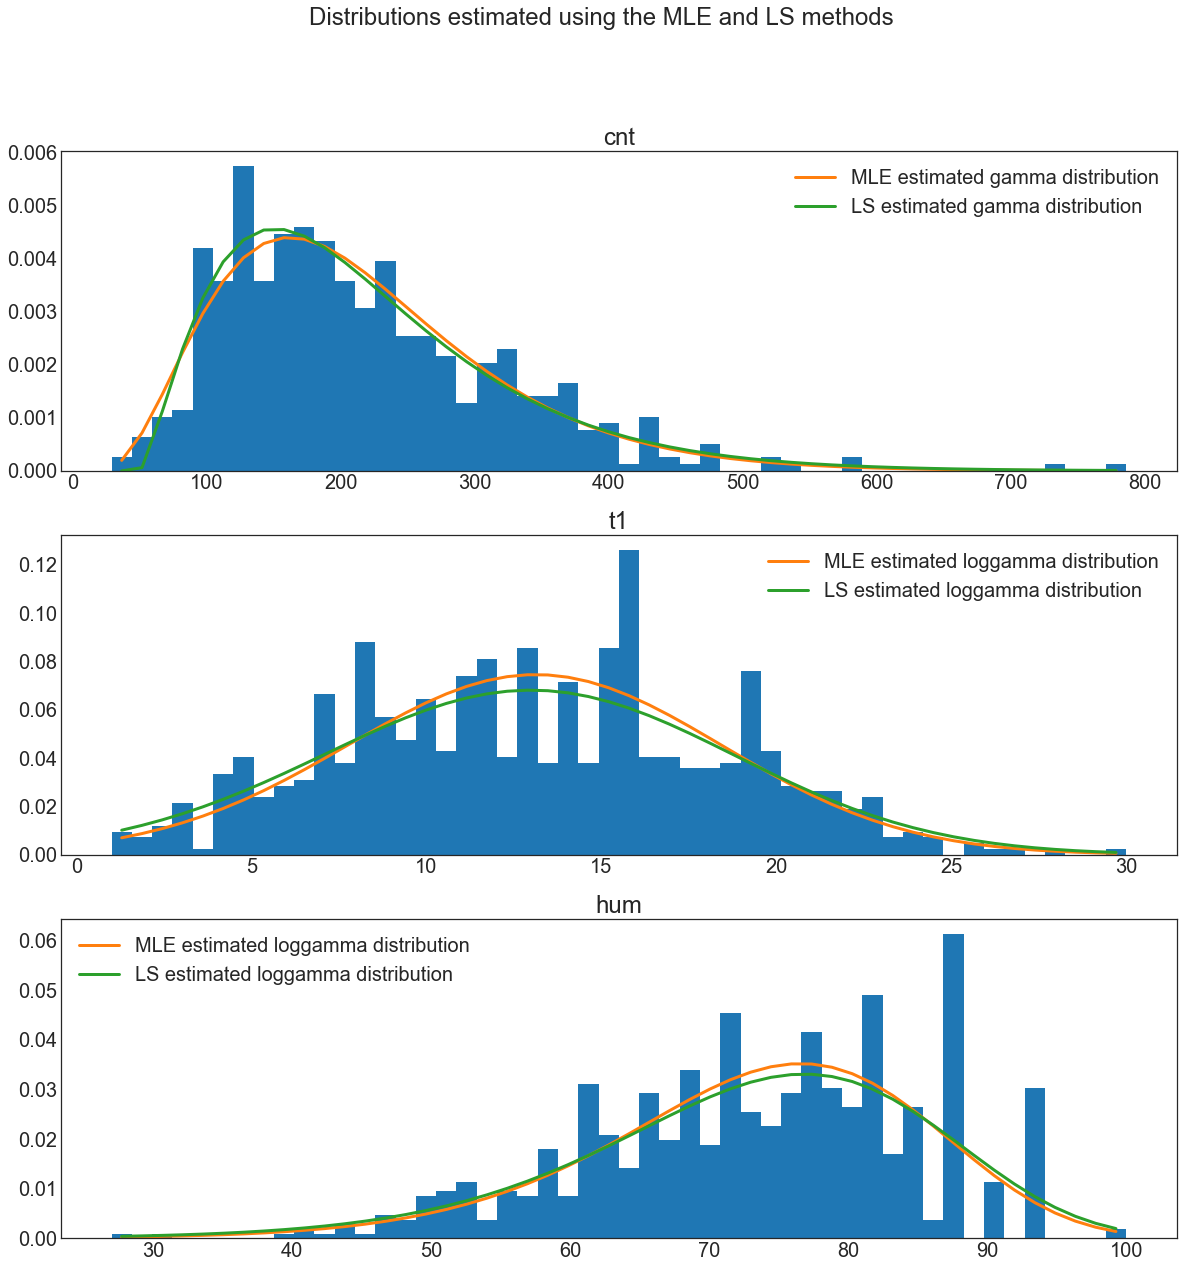

In [31]:
_, axes = plt.subplots(nrows=3)
plt.suptitle('Distributions estimated using the MLE and LS methods')
for i, key in enumerate(chosen_vars.keys()):
    plot_mle_ls(chosen_vars[key][0], chosen_vars[key][1], ax=axes.flatten()[i])

In [36]:
# visualizing qqplots for chosen vars and theoretical distributions estimated using MLE method
# displaying pvalues from Kolmogorov-Smirnov and Cramér–von Mises tests
def qq_plot(series, distribution, ax=plt):
    x = np.linspace(np.min(series), np.max(series), 100)
    percs = np.linspace(0, 100, 100)
    qn_sample = np.percentile(series, percs)
    dist_params = get_distribution_mle(series, eval(distribution))
    qn_dist =  eval(distribution).ppf(percs / 100.0, *dist_params)
    
    ax.plot(qn_sample, qn_dist, ls="", marker="o", markersize=6)
    ax.plot(x, x, color="k", ls="--")
    ax.set_xlabel('Empirical quantiles')
    ax.set_ylabel('Theoretical quantiles')
    
    ks_res = kstest(series, distribution, dist_params, N=100)
    cvm_res = cramervonmises(series, distribution, dist_params)
    print(series.name, ks_res, cvm_res, sep='\n', end='\n-------------')
    #print('------------------')
    ax.title.set_text(f'{series.name} series, {distribution} distribution \n'
                      f'Kolmogorov-Smirnov test p-value: {round(ks_res[1], 3)},  '
                      f'Cramér–von Mises test p-value: {round(cvm_res.pvalue, 3)}')

cnt
KstestResult(statistic=0.0292021932852507, pvalue=0.7575486797617565)
CramerVonMisesResult(statistic=0.06905256126077873, pvalue=0.7576094023604718)
-------------t1
KstestResult(statistic=0.047671916374341594, pvalue=0.07174489322402422)
CramerVonMisesResult(statistic=0.22335480711093797, pvalue=0.22646617889785992)
-------------hum
KstestResult(statistic=0.046008375313874805, pvalue=0.08966402832959264)
CramerVonMisesResult(statistic=0.21895223277403394, pvalue=0.23359720951674667)
-------------

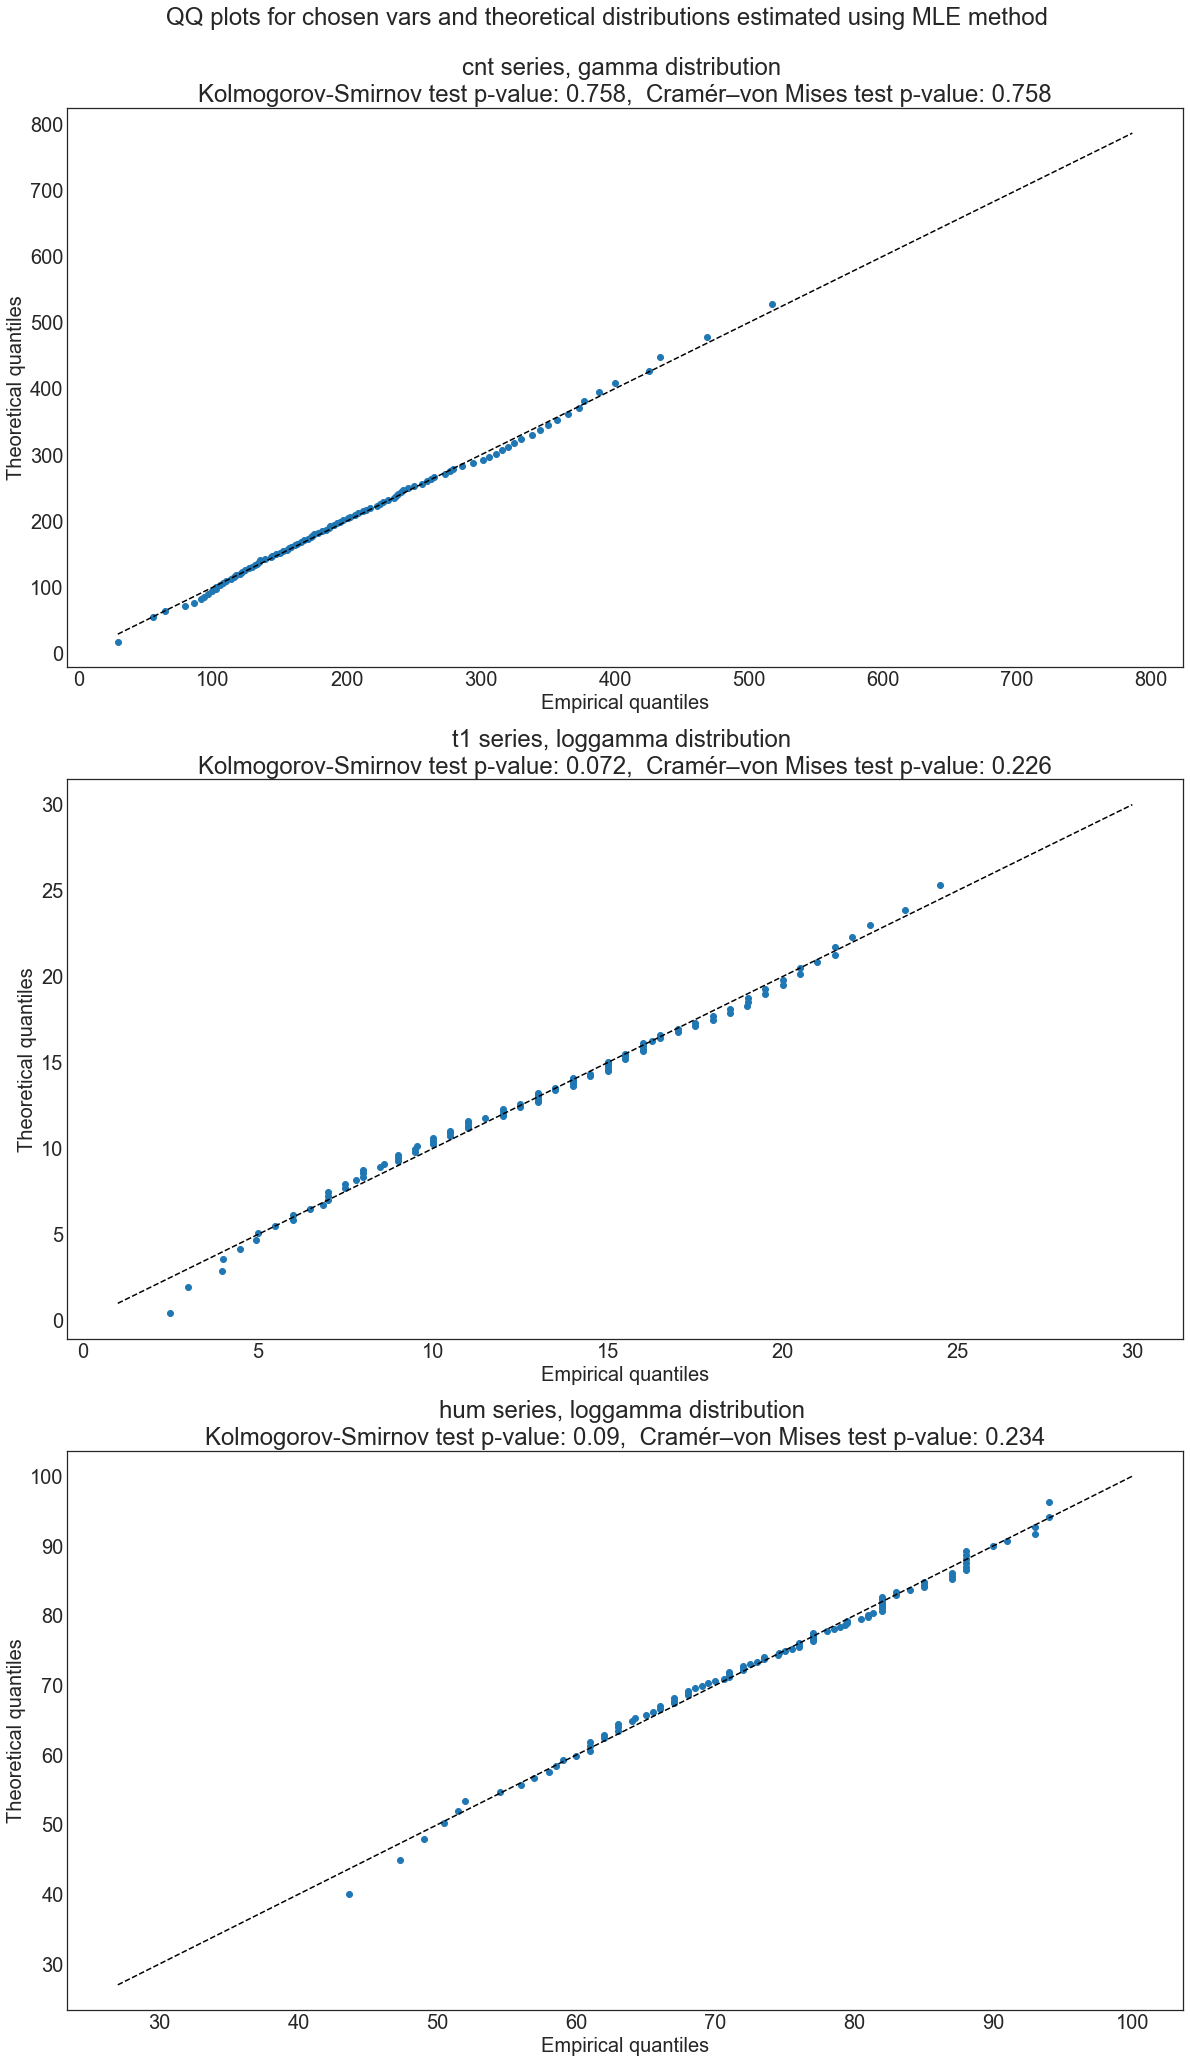

In [37]:
_, axes = plt.subplots(nrows=3, figsize=(20, 35))
plt.suptitle('QQ plots for chosen vars and theoretical distributions estimated using MLE method', y=0.92)
for i, key in enumerate(chosen_vars.keys()):
     qq_plot(chosen_vars[key][0], chosen_vars[key][1], ax=axes.flatten()[i])